## Implementing a Review classification model with Keras, MXNet and SageMaker
 The solution demotrates a Distributed Learning system implementing custom generator to train on sprase libsvm data.

### Background 

#### Data set: Amazon Customer Reviews Dataset
   
    Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazon’s iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. Over 130+ million customer reviews are available to researchers as part of this dataset.
 
#### Approach
   1. The Review classficiation is NLP machine learning model to predict whether a review posted by the customer is positive or negative. For the sake of simplification, we have converted the ratings provided by the customer into a binary target variable with value equals to 1 when ratings were either 4 or 5. 

   2. In present work, after spilitting the data into train and test we created a feature engineerng pipeline on training data using natural language processing techiniques. The dataset was futher split into 10 chunks to demonstrate distributed learning, where during training not more than 1204 [batch_size] records are loaded onto memory at a time.
   
   
####  Setup
This notebook was created and tested on an ml.p2.xlarge notebook instance.

Let's start by specifying:

1. The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
2. The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the get_execution_role() call with the appropriate full IAM role arn string(s).

In [ ]:
from sagemaker import get_execution_role
from sagemaker.session import Session
import boto3

bucket = '<your_s3_bucket_name_here>'
custom_code_upload_location = 's3://{}/sagemaker/DEMO-Distributed-learning-Keras/customcode'.format(bucket)
model_artifacts_location = 's3://{}/sagemaker/DEMO-Distributed-learning-Keras/artifacts'.format(bucket)

role = get_execution_role()

### Data
##### Explore
Let's start by bringing in our dataset from an S3 public bucket. As mentioned above, this contains 1 to 5 star ratings from over 2M Amazon customers on over 160K digital videos. More details on this dataset can be found at its AWS Public Datasets page.

Note, because this dataset is over a half gigabyte, the load from S3 may take ~10 minutes. Also, since Amazon SageMaker Notebooks start with a 5GB persistent volume by default, and we don't need to keep this data on our instance for long, we'll bring it to the temporary volume (which has up to 20GB of storage).


Let's read the data into a Pandas DataFrame so that we can begin to understand it.

Note, we'll set error_bad_lines=False when reading the file in as there appear to be a very small number of records which would create a problem otherwise.

In [2]:
import pandas as pd
import csv
fname = 's3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz'
df = pd.read_csv(fname,sep='\t',delimiter='\t',error_bad_lines=False)

b'Skipping line 92523: expected 15 fields, saw 22\n'
b'Skipping line 343254: expected 15 fields, saw 22\n'
b'Skipping line 524626: expected 15 fields, saw 22\n'
b'Skipping line 623024: expected 15 fields, saw 22\n'
b'Skipping line 977412: expected 15 fields, saw 22\n'
b'Skipping line 1496867: expected 15 fields, saw 22\n'
b'Skipping line 1711638: expected 15 fields, saw 22\n'
b'Skipping line 1787213: expected 15 fields, saw 22\n'
b'Skipping line 2395306: expected 15 fields, saw 22\n'
b'Skipping line 2527690: expected 15 fields, saw 22\n'



We can see this dataset includes information like:

   1. marketplace: 2-letter country code (in this case all "US").
   2. customer_id: Random identifier that can be used to aggregate reviews written by a single author.
   3. review_id: A unique ID for the review.
   4. product_id: The Amazon Standard Identification Number (ASIN). http://www.amazon.com/dp/<ASIN> links to the product's detail page.
   5. product_parent: The parent of that ASIN. Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
   6. product_title: Title description of the product.
   7. product_category: Broad product category that can be used to group reviews (in this case digital videos).
   8. star_rating: The review's rating (1 to 5 stars).
   9. helpful_votes: Number of helpful votes for the review.
   10. total_votes: Number of total votes the review received.
   11. vine: Was the review written as part of the Vine program?
   12. verified_purchase: Was the review from a verified purchase?
   13.  review_headline: The title of the review itself.
   14. review_body: The text of the review.
   15.  review_date: The date the review was written.
    
    
For this example, let's limit ourselves 'verified_purchase','review_headline','review_body','product_title','helpful_votes and star_rating. 


##### Pre-processing
1. Replace any NaN values with empty string
2. Create Target column based the star rating

In [15]:
import numpy as np
def pre_process(df):
    df.fillna(
        value={'review_body': '', 'review_headline': ''}, inplace=True)
    df.fillna(
        value={'verified_purchase': 'Unk'}, inplace=True)

    df.fillna(0, inplace=True)
    return df

df = pre_process(df)

df.review_date = pd.to_datetime(df.review_date)
df['target'] = np.where(df['star_rating']>=4,1,0)

##### Split the data into Train, validation and Test set
Note: We have used stratefied sampling as the criteria for splittng the data; stratefied sampling on the target variable insures same distribution of the varible across all the splits.

In [75]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.10, random_state=0)

sss.get_n_splits(df, df['target'])
for train_index, test_index in sss.split(df, df['target']):
    X_train_vallid , X_test = df.iloc[train_index], df.iloc[test_index]
    
    
sss.get_n_splits(X_train_vallid, X_train_vallid['target'])    
for train_index, test_index in sss.split(X_train_vallid, X_train_vallid['target']):
    X_train , X_valid = X_train_vallid.iloc[train_index], X_train_vallid.iloc[test_index]
    
    
print(X_train.target.value_counts()[1]/(X_train.target.value_counts().sum()))
print(X_test.target.value_counts()[1]/(X_test.target.value_counts().sum()))
print(X_valid.target.value_counts()[1]/(X_valid.target.value_counts().sum()))

0.7920667165021078
0.7920667275251041
0.7920667165021078


##### Feature Engineering
    1. One-hot encoder for 'verified_purchase'
    2. CountVectorizer followed by absolute scaling for 'review_headline'
    3. CountVectorizer followed by absolute scaling for 'review_body'
    4. CountVectorizer followed by absolute scaling for 'product_title'
    5. SimpleImputer followed by MinMaxScaler for 'helpful_votes'
    6. Concatenate all the previous vector in one Pipeline

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import sklearn.pipeline
from sklearn.preprocessing import OneHotEncoder,MaxAbsScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

cat_transformer = sklearn.pipeline.Pipeline(steps=[('cat_Vectorizer', 
                                                    OneHotEncoder(handle_unknown='ignore'))])

headline_vectorizer = CountVectorizer(stop_words='english',
                                 binary=False,
                                 max_df=0.7,
                                 min_df=100,
                                 ngram_range=(3, 3),
                                 max_features=500,
                                 analyzer='char_wb')

headline_transformer = sklearn.pipeline.Pipeline(steps=[
            ('Vectorizer', headline_vectorizer),
            ('feature_vec_sclr', MaxAbsScaler())])


body_vectorizer = CountVectorizer(stop_words='english',
                                 binary=False,
                                 max_df=0.7,
                                 min_df=100,
                                 ngram_range=(3, 3),
                                 max_features=5000,
                                 analyzer='char_wb')

body_transformer = sklearn.pipeline.Pipeline(steps=[
            ('Vectorizer', body_vectorizer),
            ('feature_vec_sclr', MaxAbsScaler())])


product_vectorizer = CountVectorizer(stop_words='english',
                                 binary=False,
                                 max_df=0.7,
                                 min_df=100,
                                 ngram_range=(3, 3),
                                 max_features=500,
                                 analyzer='char_wb')

product_transformer = sklearn.pipeline.Pipeline(steps=[
            ('Vectorizer', product_vectorizer),
            ('feature_vec_sclr', MaxAbsScaler())])

steps = [('feature_Imputer', SimpleImputer(strategy='most_frequent'))
            , ('feature_scaler', MinMaxScaler())]
numeric_transformer = sklearn.pipeline.Pipeline(steps)
    

union = ColumnTransformer(
            transformers=[ ('cat', cat_transformer, [0]),
                          ('headline', headline_transformer, 1),
                          ('body', body_transformer, 2),
                          ('product', product_transformer, 3),
                          ('num', numeric_transformer, [4])
                          ],
            remainder="drop")

steps = [('features', union)]
pipeline = sklearn.pipeline.Pipeline(steps)

In [76]:
cols = ['verified_purchase','review_headline','review_body','product_title','helpful_votes']
import time
start = time.time()
train_vec = pipeline.fit_transform(X_train[cols])
end = time.time()

It took approximatly 10 mins to fit the pipeline on 3M records

In [112]:
! mkdir ./data

mkdir: cannot create directory ‘./data’: File exists


#### Splitting the data into 10 different chunks to demonstrate distributed learning

In [200]:
from sklearn.datasets import dump_svmlight_file
train_df = np.array_split(X_train, 10)
i=0
for df_split in train_df:     
    trans = pipeline.transform(df_split[cols])
    dump_svmlight_file(trans,df_split['target'].values,'data/train/file_'+str(i))
    i=i+1
    
train_df = np.array_split(X_valid, 10)
i=0
for df_split in train_df:     
    trans = pipeline.transform(df_split[cols])   
    dump_svmlight_file(trans,df_split['target'].values,'data/valid/file_'+str(i))
    i=i+1    
    
train_df = np.array_split(X_test, 10)
i=0
for df_split in train_df:     
    trans = pipeline.transform(df_split[cols])   
    dump_svmlight_file(trans,df_split['target'].values,'data/holdout/file_'+str(i))
    i=i+1   

In [297]:
### repalce with your bucket name
! aws s3 cp ./data/ s3://<your bucket name>/sagemaker/DEMO-Distributed-learning-Keras/data/ --recursive --acl bucket-owner-full-control

/bin/sh: your: No such file or directory


### Train with SageMaker


Wrap Code
To use SageMaker's pre-built MXNet container, we'll need to wrap our code from above into a Python script. There's a great deal of flexibility in using SageMaker's pre-built containers, and detailed documentation can be found here, but for our example, it consisted of:

    1.f1 custom function to optmize around
    2.readfile function to read individual files
    3.Custom generator to loop through files and records to return batchs in sequence
    4.parse_args to parser to read all arguements
    5.train function to train the Neural network model
    6.threadsafe_iter class and threadsafe_generator to make the custom generator threadsafe
    7.input_fn function to convert inference payload to numpy vector


In [299]:
!cat Mailerclass_mxnet_dnn_II.py

# #Standard Libraries
import sys
import os
from os import walk

import json
import threading

import argparse


import numpy as np


import mxnet as mx

##Keras Imports
import keras
from keras import backend as K
from keras.layers import Dense, Dropout, Input, BatchNormalization, Activation

from keras.models import Sequential
from keras.models import save_mxnet_model
from keras.models import load_model
from keras.optimizers import RMSprop, Adam, SGD

from keras.utils import multi_gpu_model


input_shape = (6003,)


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
    

In [ ]:
### Submitting a sagemaker training job

from sagemaker.mxnet import MXNet
mnist_dnn_estimator = MXNet(entry_point='Mailerclass_mxnet_dnn_II.py',
                        role=role,
                        output_path=model_artifacts_location,
                        code_location=custom_code_upload_location,
                        train_instance_count=1,
                        train_instance_type='ml.p3.16xlarge',
                        framework_version='1.4.1',
                        py_version='py3',
                        train_volume_size = 100,
                        distributions={'parameter_server': {'enabled': True}},
                        hyperparameters={'learning-rate': 0.01})

region = boto3.Session().region_name
train_data_location = 's3://'+bucket+'/sagemaker/DEMO-Distributed-learning-Keras/data/train/'
test_data_location =  's3://'+bucket+'/sagemaker/DEMO-Distributed-learning-Keras/data/valid/'

mnist_dnn_estimator.fit({'train': train_data_location, 'test': test_data_location})

### Batch inference
Run the batch inference on the test set

In [272]:
output_path = 's3://'+bucket+'/sagemaker/DEMO-Distributed-learning-Keras/data/holdout-predictions/'
input_path  = 's3://'+bucket+'/sagemaker/DEMO-Distributed-learning-Keras/data/holdout/'

transformer = mnist_dnn_estimator.transformer(instance_count=2, 
                                             instance_type='ml.p3.16xlarge', 
                                             assemble_with='Line', 
                                             accept='text/csv',
                                             max_payload=3,
                                             output_path=output_path,
                                             env = {'SAGEMAKER_MODEL_SERVER_TIMEOUT' : '3600' })
transformer.transform(input_path, 
                      content_type='text/csv',
                      #input_filter="$[1:]" ,
                      #join_source='Input',
                      split_type='Line')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


### Evaluation
1. read_predictions: Read results from the batch transform
2. Analyze and plot the PR-AUC and ROC-AUC curve 

In [284]:
### Reading results and Analyzing
from sklearn import  metrics
import matplotlib
import pandas as pd
matplotlib.use('agg', warn=False, force=True)
from matplotlib import pyplot as plt

%matplotlib inline 

def analyze_results(labels, predictions):
    precision, recall, thresholds = metrics.precision_recall_curve(labels, predictions)
    auc = metrics.auc(recall, precision)
    
    fpr, tpr, _ = metrics.roc_curve(labels, predictions)
    roc_auc_score = metrics.roc_auc_score(labels, predictions)
    
    print('Neural-Nets: ROC auc=%.3f' % ( roc_auc_score))
    
    plt.plot(fpr, tpr, label="data 1, auc=" + str(roc_auc_score))
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.legend(loc=4)
    plt.show()
    
    
    lr_precision, lr_recall, _ = metrics.precision_recall_curve(labels, predictions)
    lr_auc = metrics.auc(lr_recall, lr_precision)
    # summarize scores
    print('Neural-Nets: PR auc=%.3f' % ( lr_auc))
    # plot the precision-recall curves
    no_skill = len(labels[labels==1.0]) / len(labels)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    
    plt.plot(lr_recall, lr_precision, marker='.', label='Neural-Nets')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    
    return auc

def read_predictions(prefix):
    s3 = boto3.resource('s3')
    my_bucket = s3.Bucket(bucket)
    files = 0 
    preds=[]
    for object_summary in my_bucket.objects.filter(Prefix=prefix):
        print(object_summary.key)
        obj = s3.Object(bucket, object_summary.key)
        filename = 's3://'+ bucket+ '/' + object_summary.key
        res = pd.read_csv(filename, header=None , sep='\t')
        print("length:",len(res.iloc[:,0].values.tolist()))
        preds = preds + res.iloc[:,0].values.tolist()
        files = files +1
    return preds



In [ ]:
prefix ='sagemaker/DEMO-Distributed-learning-Keras/data/holdout-predictions/'
y_dnn_pred = read_predictions(prefix)

Neural-Nets: ROC auc=0.975


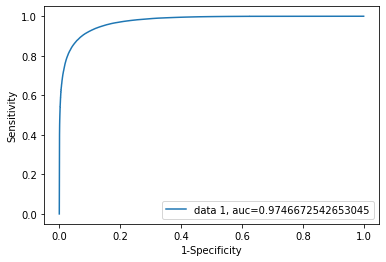

Neural-Nets: PR auc=0.993


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


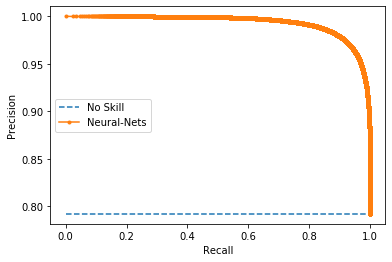

0.992858168571398

In [286]:
analyze_results(X_test['target'].values,y_dnn_pred)

### Results
1. Model achieved an ROC-AUC of 0.97 on the holdout set below are some reviews classified as good and bad by the model

#### Reviews classified as Good by the model
       1. 'Awesome show, wish they would have continued it!',
       2. 'Great movie.',
       3. 'Absolutely beautiful!!!', 
       4. 'I love this show &#60;3',
       5. 'One of my favorite kind of shows. Love I!'
       
#### Reviews classified as Bad by the model       
     1. If I could give this less than 1 star I would.  The worst movie I've seen in ages.  The acting was less than high school level.  The Mockingjay character was mind numbingly boring and droll.  She was terrible.  The characters were beyond pathetic.  1 hour and 40 minutes of pure torture and inane plot, script combined with terrible CGI and effects I found myself wanting to consume mass quantities of alcohol.  The whole Hunger Game sage is a total waste of time.  How anyone can say this is anything but pure boredom is beyond me.
     2. slow and boring, boring, boring, just like the book
     3. "Awful. A waste of money. A waste of time. Boring. Predictable. I gave up for the sake of my sanity about 20 minutes before it was over. Sandler and Barrymore must have been bored to tears with nothing to do, under contract to do something, and just didn't care........",
     4.'Horrible movie. Mediocre acting, terrible plot, confusing and boring.',
     5.'The movie is a real waste of time and money, poor actors, poor story, poor locations... really awful movie. I waste my money with this piece of crap.',
